#FOOD VISION

##Checking GPU

In [ ]:
!nvidia-smi

Tue Aug  9 18:31:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Getting the data

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
'food101' in datasets_list

True

In [ ]:
(train_data, test_data), (ds_info) = tfds.load('food101',
                                               split=['train', 'validation'],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteDNQZAI/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteDNQZAI/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


##Getting used to the data

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_sample = train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Checking shapes
for image, label in train_data.take(10):
  print(image.shape, class_names[label])

(512, 512, 3) grilled_cheese_sandwich
(512, 512, 3) french_toast
(512, 512, 3) hamburger
(512, 512, 3) tacos
(512, 512, 3) samosa
(384, 512, 3) chocolate_mousse
(512, 382, 3) ice_cream
(512, 512, 3) beef_tartare
(512, 512, 3) red_velvet_cake
(512, 512, 3) carrot_cake


Different shapes of the images

##Visualizing images

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def show_10_images():
  plt.figure(figsize=(20, 10))
  for i, (image, label) in enumerate(train_data.take(10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis(False)

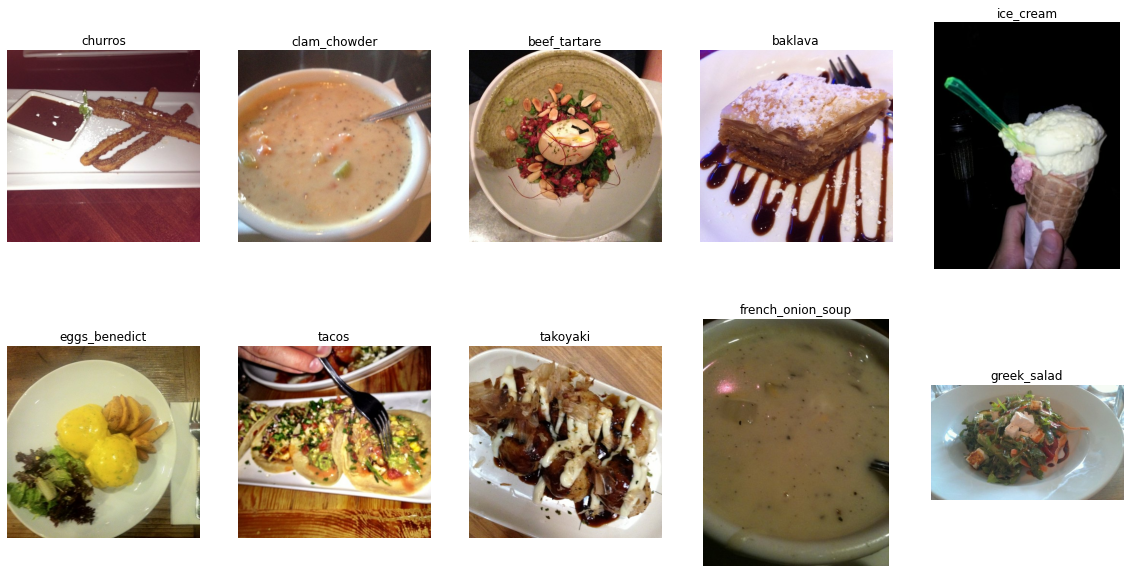

In [ ]:
show_10_images()

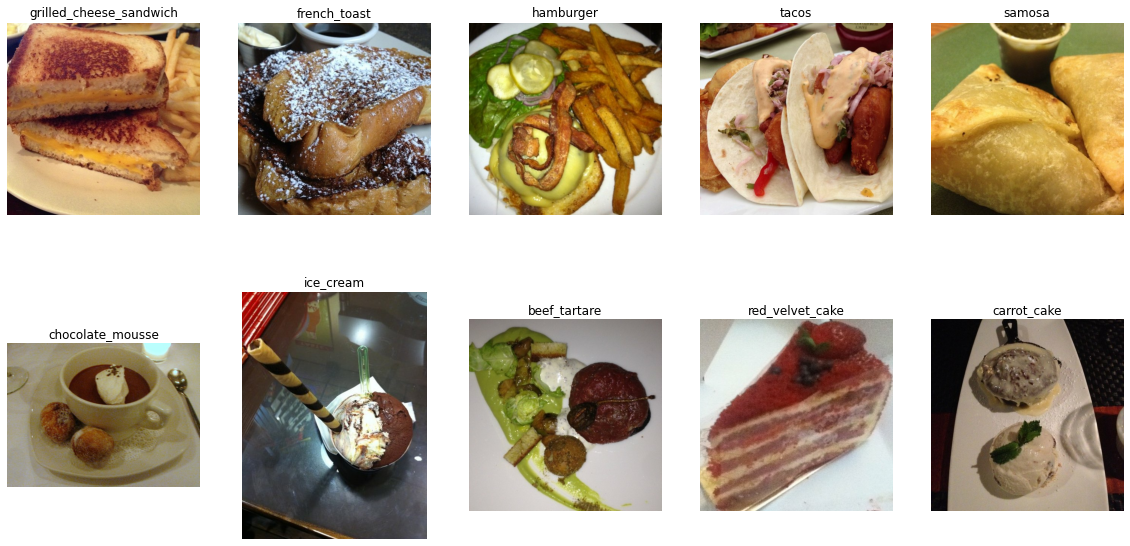

In [ ]:
show_10_images()

##Creating preprocessing functions
* normalize data <0, 1>
* resize to (224, 224)

In [ ]:
import tensorflow as tf

In [ ]:
def preprocess(image, label, size=224):
  return tf.cast(tf.image.resize(image, (size, size)), dtype=tf.float32), label  

##Batch and preprocess images

In [ ]:
# Preprocess data
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle data and turn into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle and batch test data
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

##Creating modelling callbacks

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='tensorboard/first_model')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('checkpoints/first_model.ckpt',
                                                         monitor='val_accuracy',
                                                         save_best_model=True,
                                                         save_weights_only=True)

## Setting Mixed Precision training

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

##Building Feature Extraction Model

In [ ]:
backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = backbone(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='glob_avg_pool')(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer', dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 glob_avg_pool (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#Checking dtypes of the layers
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
glob_avg_pool True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [ ]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=3,
                                                       restore_best_weights=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=.2,
                                                          patience=2,
                                                          verbose=1,
                                                          min_lr=1e-7)

In [ ]:
model.fit(train_data,
          steps_per_epoch=len(train_data),
          epochs=100,
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback, reduce_lr_callback])

Epoch 1/100
2368/2368 [==============================] - 240s 100ms/step - loss: 1.4660 - accuracy: 0.6264 - val_loss: 1.1773 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 223s 93ms/step - loss: 1.2254 - accuracy: 0.6820 - val_loss: 1.1084 - val_accuracy: 0.7016 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 227s 95ms/step - loss: 1.1016 - accuracy: 0.7128 - val_loss: 1.0845 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 223s 94ms/step - loss: 1.0159 - accuracy: 0.7355 - val_loss: 1.0643 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - 231s 97ms/step - loss: 0.9492 - accuracy: 0.7497 - val_loss: 1.0667 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.7639
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [=======

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 54s 66ms/step - loss: 1.0339 - accuracy: 0.7196


[1.033851981163025, 0.719603955745697]

In [ ]:
model.save('feature_extraction_model')

INFO:tensorflow:Assets written to: feature_extraction_model/assets


INFO:tensorflow:Assets written to: feature_extraction_model/assets


##Building Fine Tuning Model

In [ ]:
model_2 = tf.keras.models.load_model('feature_extraction_model')


model_2.evaluate(test_data)

790/790 [==============================] - 58s 70ms/step - loss: 1.0339 - accuracy: 0.7196


[1.033852219581604, 0.719603955745697]

In [ ]:
#Checking dtypes of the layers
for layer in model_2.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

model_2.evaluate(test_data)

input_2 True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
glob_avg_pool True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">
790/790 [==============================] - 56s 70ms/step - loss: 1.0339 - accuracy: 0.7196


[1.0338523387908936, 0.719603955745697]

In [ ]:
history_2 = model_2.fit(train_data,
                        steps_per_epoch=len(train_data),
                        epochs=100,
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback, reduce_lr_callback])

Epoch 1/100
2368/2368 [==============================] - 406s 165ms/step - loss: 0.6598 - accuracy: 0.8244 - val_loss: 0.9611 - val_accuracy: 0.7423 - lr: 8.0000e-06
Epoch 2/100
2368/2368 [==============================] - 388s 163ms/step - loss: 0.5798 - accuracy: 0.8463 - val_loss: 0.9613 - val_accuracy: 0.7456 - lr: 8.0000e-06
Epoch 3/100
2368/2368 [==============================] - 387s 163ms/step - loss: 0.5210 - accuracy: 0.8634 - val_loss: 0.9570 - val_accuracy: 0.7505 - lr: 8.0000e-06
Epoch 4/100
2368/2368 [==============================] - 385s 162ms/step - loss: 0.4682 - accuracy: 0.8788 - val_loss: 0.9745 - val_accuracy: 0.7509 - lr: 8.0000e-06
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8920
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
2368/2368 [==============================] - 381s 160ms/step - loss: 0.4195 - accuracy: 0.8920 - val_loss: 0.9873 - val_accuracy: 0.7513 - lr: 8.0000e-06
Epoch 